In [23]:
import os

In [24]:
%pwd

'C:\\Users\\RICH-FILES\\Desktop\\ml\\client-subscription-prediction'

In [25]:
os.chdir("../")

In [26]:
%pwd

'C:\\Users\\RICH-FILES\\Desktop\\ml'

In [27]:
project_dir = "C:/Users/RICH-FILES/Desktop/ml/client-subscription-prediction"
os.chdir(project_dir)

In [28]:
# create the entity
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class DataTransformationConfig:
    """Data Transformation Configuration"""
    root_dir: Path
    data_path: Path
   

In [29]:
from clientClassifier.constants import *
from clientClassifier.utils.common import read_yaml, create_directories

In [30]:
class ConfigurationManager:
    def __init__(
        self, 
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH,
        schema_filepath = SCHEMA_FILE_PATH):
        
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)
        
        create_directories([self.config.artifacts_root])
  

    def get_data_transformation_config(self) -> DataTransformationConfig:
        config = self.config.data_transformation
   
        
        # create directories if not exist
        create_directories([config.root_dir])
        
        data_transformation_config = DataTransformationConfig(
            root_dir=  config.root_dir,
            data_path= config.data_path,
        )
        return data_transformation_config

In [31]:
#creating the components
import os
from clientClassifier import logger
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline   
from imblearn.over_sampling import SMOTE

In [32]:
class DataTransformation:
    def __init__(self, config: DataTransformationConfig):
        self.config = config

    def initiate_data_transformation(self):
        logger.info(f"Data transformation started")
        
        # read the data
        df = pd.read_csv(self.config.data_path)
        
         # showing the first 5 rows of the data
        logger.info(f"Data sample: {df.head()}")
        
        #check data info
        logger.info(f"Data info: {df.info()}")
        

        
        
  
        
        # explain what each column represents 
        logger.info(f"Data columns description:")   
        logger.info(f"1. age: Age of the client")
        logger.info(f"2. job: Type of job (e.g., admin, technician, etc.)")
        logger.info(f"3. marital: Marital status (e.g., single, married, divorced)")        
        logger.info(f"4. education: Level of education (e.g., primary, secondary, tertiary)")   
        logger.info(f"5. default: Whether the client has credit in default (yes/no)")   
        logger.info(f"6. balance: Average yearly balance in euros")     
        logger.info(f"7. housing: Whether the client has a housing loan (yes/no)")      
        logger.info(f"8. loan: Whether the client has a personal loan (yes/no)")    
        logger.info(f"9. contact: Type of communication used to contact the client (e.g., cellular, telephone)")        
        logger.info(f"10. day: Last contact day of the month (1-31)")           
        logger.info(f"11. month: Last contact month of year")               
        logger.info(f"12. duration: Duration of the last contact in seconds")                       
        logger.info(f"13. campaign: Number of contacts performed during this campaign for this client")                         
        logger.info(f"14. pdays: Number of days since the client was last contacted from a previous campaign (999 means client was not previously contacted)")  
        logger.info(f"15. previous: Number of contacts performed before this campaign for this client") 
        logger.info(f"16. poutcome: Outcome of the previous marketing campaign (e.g., success, failure)")
        logger.info(f"17. y: Target variable (whether the client subscribed to a term deposit or not)")
               
        
        print()
        print('<' * 70)
        print()
        
         # check for missing values
        missing_values = df.isnull().sum()
        if missing_values.any():
            logger.warning(f"Missing values found in the data: {missing_values}")
        else:
            logger.info(f"No missing values found in the data") 
            
        # check for duplicates
        duplicates = df.duplicated().sum()
        if duplicates > 0:
            logger.warning(f"Duplicates found in the data: {duplicates}")
        else:
            logger.info(f"No duplicates found in the data") 
            
        # check for outliers    
        # (this is a simple example, in practice you would use more sophisticated methods)  
        outliers = df.describe()    
        logger.info(f"Outliers in the data: {outliers}")
        
        # check for categorical variables   
        categorical_vars = df.select_dtypes(include=['object']).columns 
        
        if len(categorical_vars) > 0:
            logger.info(f"Categorical variables found in the data: {categorical_vars}")                 
        else:
            logger.info(f"No categorical variables found in the data")      
            
        # check for numerical variables
        numerical_vars = df.select_dtypes(include=['int64', 'float64']).columns 

        if len(numerical_vars) > 0: 
            logger.info(f"Numerical variables found in the data: {numerical_vars}")         
        else:
            logger.info(f"No numerical variables found in the data")

        # check for class imbalance
        class_counts = df['y'].value_counts()      
        logger.info(f"Class distribution in the data: {class_counts}")      
        
        if class_counts.min() / class_counts.max() < 0.2:
            logger.warning(f"Class imbalance found in the data")                
        else:   
            logger.info(f"No class imbalance found in the data")   
          
        print()
        print('<' * 70)
        print()  
        
       
        
        #check data types of all columns
        for col in df.columns:  
            print(f"Column: {col}, Data type: {df[col].dtype}")
            
        
        logger.info(f"Data types of all columns checked")
        
        print()
        print('<' * 70)
        print()
        
       
        #check data type of 'y' column
        print(f"Column: y, Data type: {df['y'].dtype}")

        
        logger.info("Target column data type changed")
        
        print()
        print('<' * 70)
        print()
        
        df['month'] = pd.to_datetime(df['month'], format='%b').dt.month
        
        print(df['y'].unique())
        print(df['y'].dtype)
        print(df['y'].head(10))

        print("here")
        #exploratory data analysis (EDA)
        df['y'].value_counts().plot(kind='bar')
        plt.title('Target Variable Distribution')   
        plt.xlabel('Target Variable')
        plt.ylabel('Count')
        plt.show()
        
        print(df.dtypes)
        print(df.head())


        # check for feature distribution based on the target variable  y    
        for col in df.select_dtypes(include=['int64', 'float64']).columns:  
            plt.figure(figsize=(8, 4))
            sns.boxplot(x='y', y=col, data=df)  
            plt.xticks(ticks=[0, 1], labels=["no", "yes"]) 
            plt.title(f'Distribution of {col} by Target Variable')
            plt.xlabel('Target Variable')
            plt.ylabel(col)
            plt.show()
            
            
        print()
        print('<' * 70)
        print()
            
            
         # check for feature distribution based on the target variable  y    
        for col in df.select_dtypes(exclude=['int64', 'float64']).columns:  
            plt.figure(figsize=(8, 4))
            sns.countplot(x=col, data=df, hue='y')
            plt.title(f'Distribution of {col} by Target Variable')
            plt.xlabel('Target Variable')
            plt.ylabel(col)
            plt.show()
            
                
                
       # check for feature correlation     
        correlation_matrix = df.select_dtypes("number").corr()  
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
        plt.title('Feature Correlation Matrix')
        plt.show()
               
        
        logger.info(f"Feature correlation in the data: {correlation_matrix}")           
        
        logger.info("Correlation matrix analysis complete.")
        print()
        print('<' * 70)
        print()
        # General observations
        logger.info("Most features in the dataset show low pairwise correlation, suggesting minimal multicollinearity.")
        logger.info("This is good for tree-based models which are not sensitive to multicollinearity, but may still affect linear models like logistic regression.")
        print()
        print('<' * 70)
        print()
        # Target correlation
        logger.info("'duration' has a very strong positive correlation with the target variable 'y'.")
        logger.info("However, 'duration' is a data leakage feature — it’s only known after the campaign call and directly impacts the prediction.")
        logger.warning("Including 'duration' would artificially inflate model performance. Exclude it during training to ensure real-world generalization.")
        print()
        print('<' * 70)
        print()
        logger.info("Consider removing 'duration' from the feature set to avoid data leakage.")
        logger.info("Features like 'previous' and 'pdays' also show some correlation with the target variable but")  
          
    
        print()
        print('<' * 70)
        print()
        # Next step suggestions
        logger.info("Consider conducting feature importance analysis using Random Forest or XGBoost to refine feature selection.")
        print()
        print('<' * 70)
        print()
        #drop the 'duration' column
        df.drop(columns=['duration'], inplace=True)
        
        logger.info(f"'duration' column dropped from the data")
        print()
        print('<' * 70)
        print()
        # drop the 'Unnamed: 0' column if it exists
        if 'Unnamed: 0' in df.columns:
            df.drop(columns=['Unnamed: 0'], inplace=True)
            logger.info(f"'Unnamed: 0' column dropped from the data")
        else:
            logger.info(f"'Unnamed: 0' column not found in the data")
            
        #drop the 'pdays' column if it exists
        if 'pdays' in df.columns:
            df.drop(columns=['pdays'], inplace=True)
            logger.info(f"'pdays' column dropped from the data")
        else:
            logger.info(f"'pdays' column not found in the data")
            
        return df
           
                              
        
        # split the data into train and test sets
    def split_data(self, df):
        logger.info(f"Splitting data into train and test sets")
        train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)
        
        # save the train and test sets to csv files
        train_set.to_csv(os.path.join(self.config.root_dir, "train.csv"), index=False)
        test_set.to_csv(os.path.join(self.config.root_dir, "test.csv"), index=False)
        
        logger.info(f"Train and test sets saved to {self.config.root_dir}")
        logger.info(f"Train set shape: {train_set.shape}")
        logger.info(f"Test set shape: {test_set.shape}")
        
        
        print(f"Train set shape: {train_set.shape}")    
        print(f"Test set shape: {test_set.shape}")
        
        
        
        return train_set, test_set
    

[2025-05-03 16:29:04,981: INFO: common: yaml file: config\config.yaml loaded successfully]
[2025-05-03 16:29:04,987: INFO: common: yaml file: params.yaml loaded successfully]
[2025-05-03 16:29:05,000: INFO: common: yaml file: schema.yaml loaded successfully]
[2025-05-03 16:29:05,025: INFO: common: created directory at: artifacts]
[2025-05-03 16:29:05,033: INFO: common: created directory at: artifacts/data_transformation]
[2025-05-03 16:29:05,036: INFO: 4276966440: Data transformation started]
[2025-05-03 16:29:05,130: INFO: 4276966440: Data sample:    age          job  marital  education default  balance housing loan  \
0   30   unemployed  married    primary      no     1787      no   no   
1   33     services  married  secondary      no     4789     yes  yes   
2   35   management   single   tertiary      no     1350     yes   no   
3   30   management  married   tertiary      no     1476     yes  yes   
4   59  blue-collar  married  secondary      no        0     yes   no   

    co

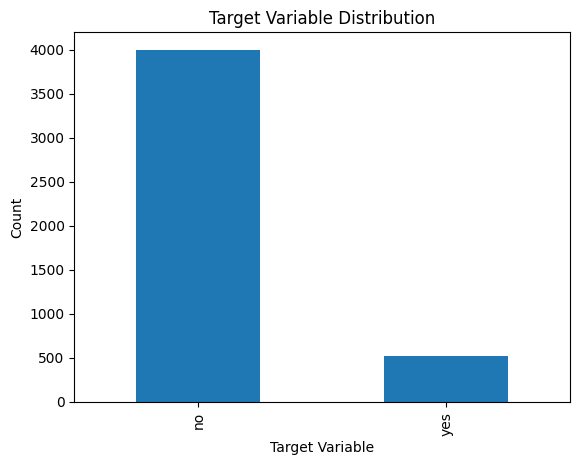

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month         int32
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object
   age          job  marital  education default  balance housing loan  \
0   30   unemployed  married    primary      no     1787      no   no   
1   33     services  married  secondary      no     4789     yes  yes   
2   35   management   single   tertiary      no     1350     yes   no   
3   30   management  married   tertiary      no     1476     yes  yes   
4   59  blue-collar  married  secondary      no        0     yes   no   

    contact  day  month  duration  campaign  pdays  previous poutcome   y  
0  cellular   19     10        79         1     -1         0  unknown  no  
1  cellular   11      5       220         1    339     

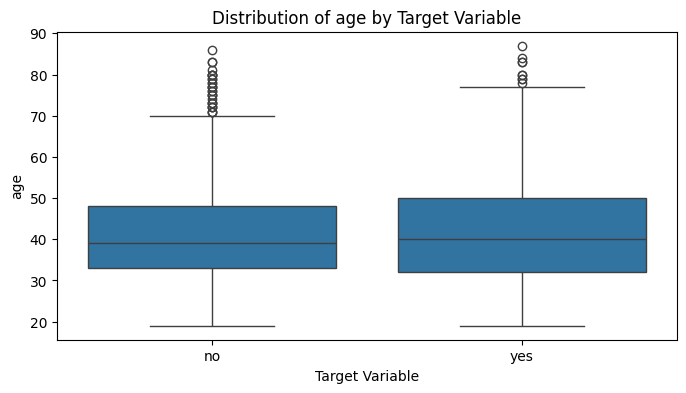

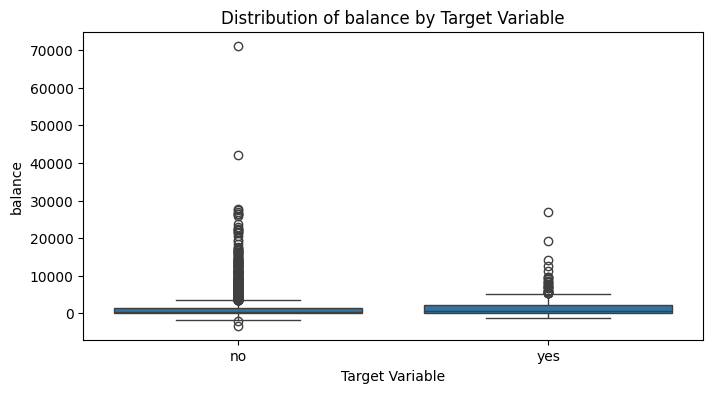

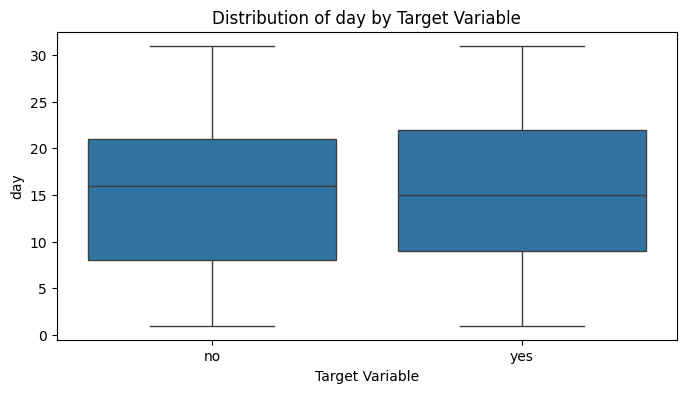

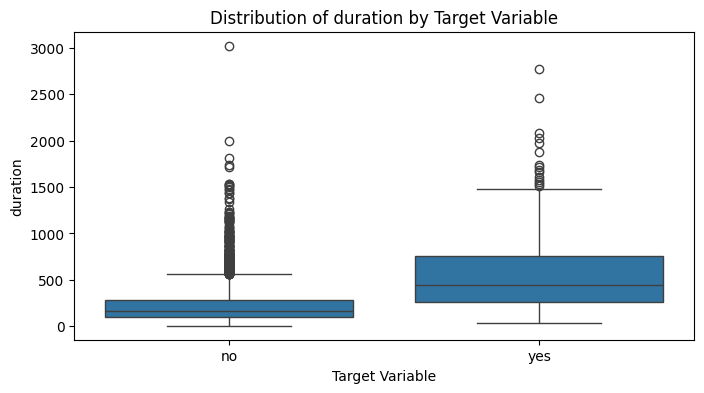

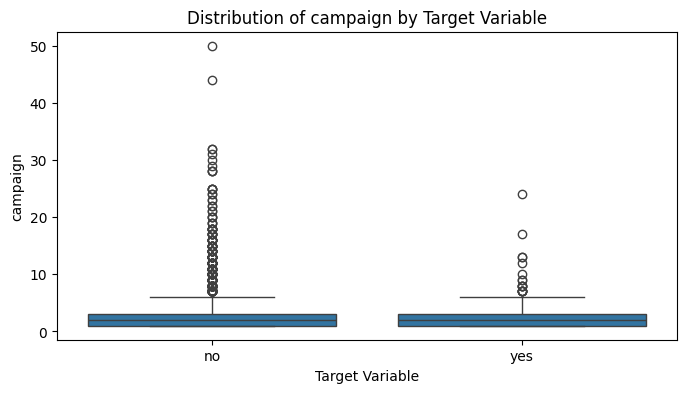

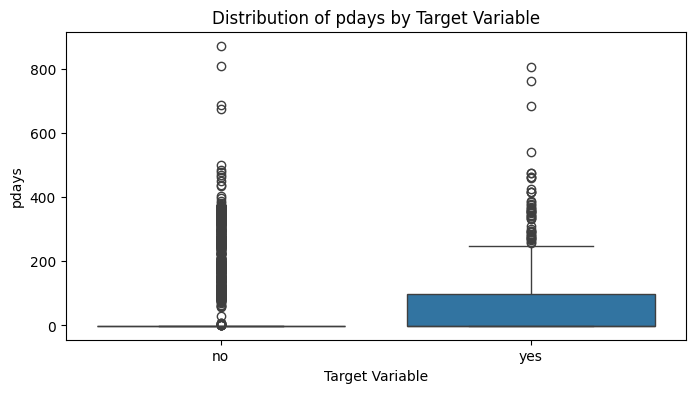

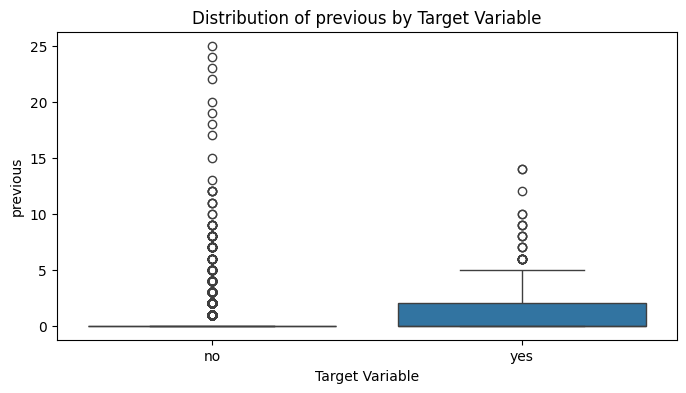


<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<



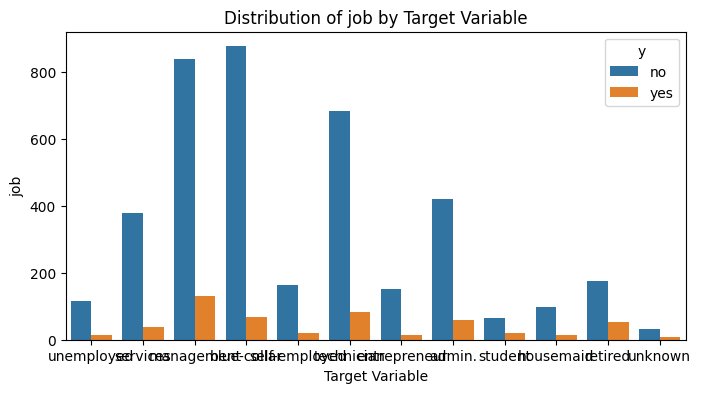

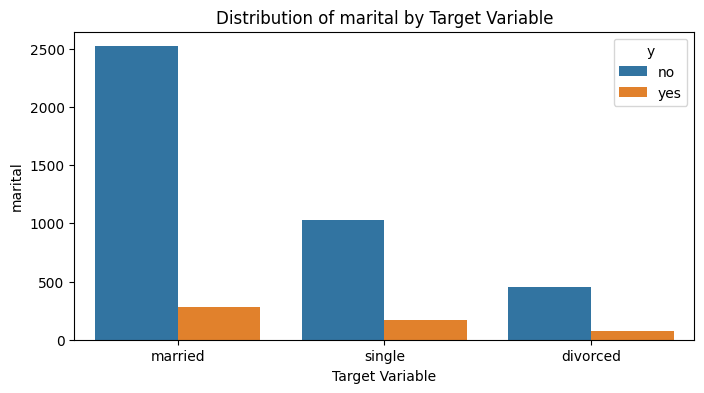

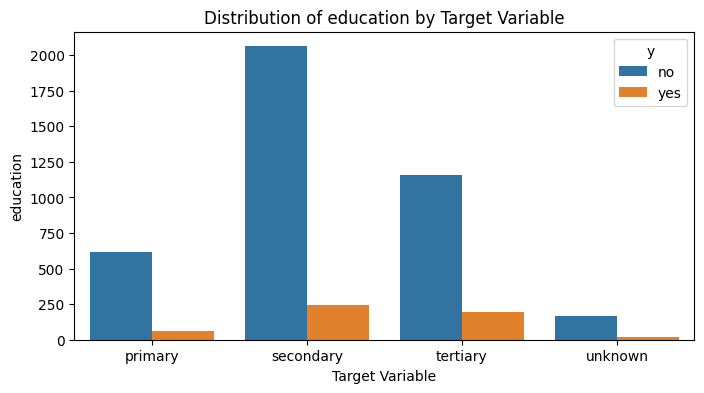

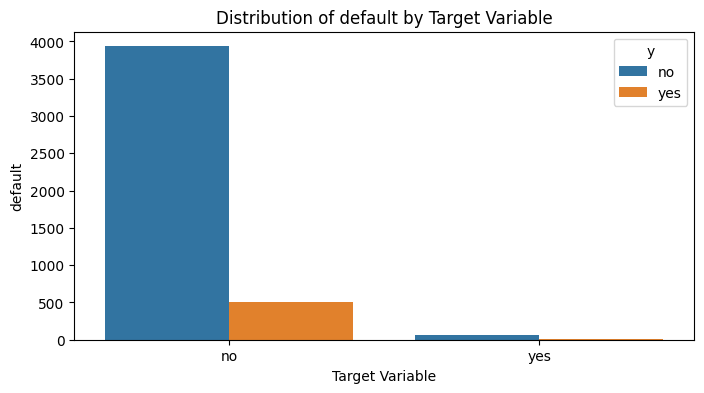

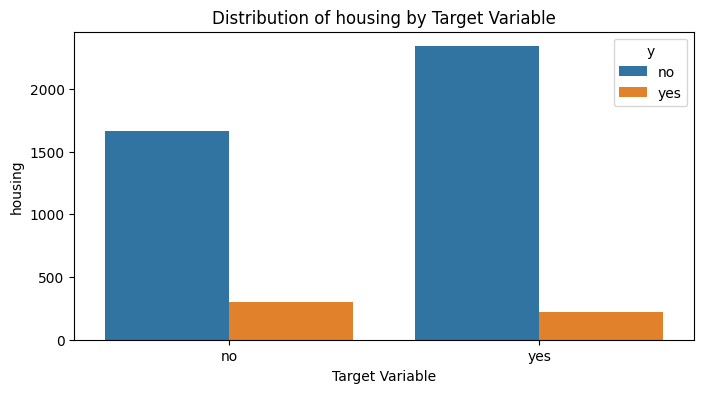

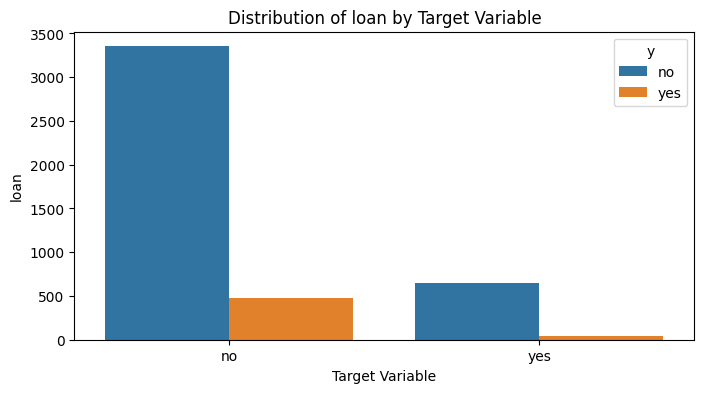

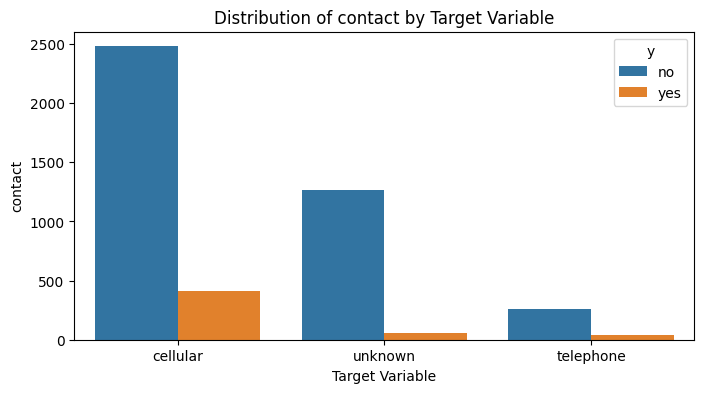

[2025-05-03 16:29:08,420: INFO: category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.]
[2025-05-03 16:29:08,447: INFO: category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.]


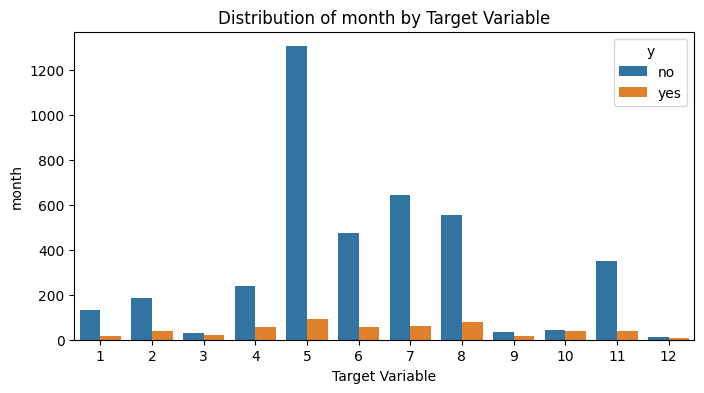

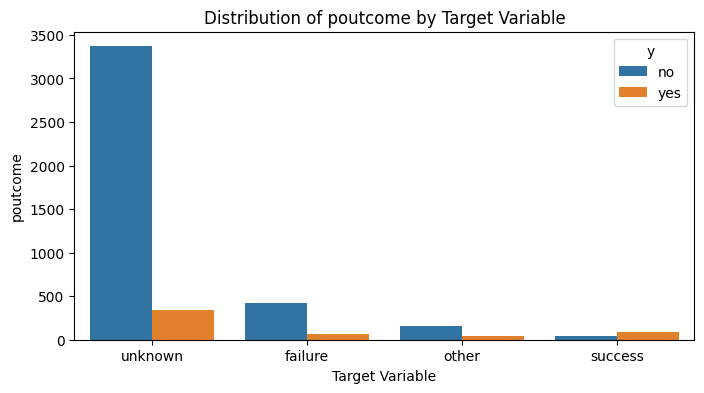

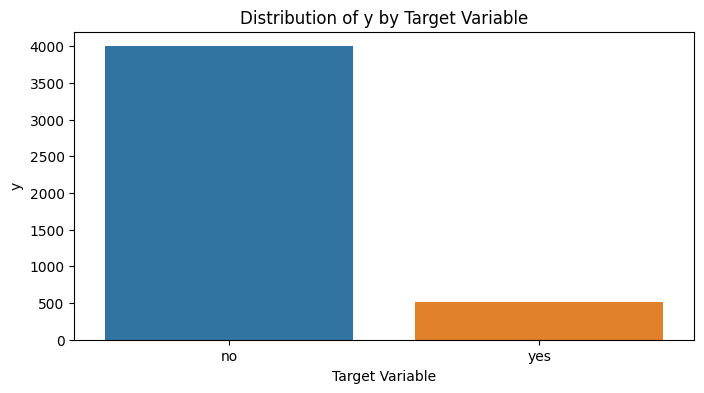

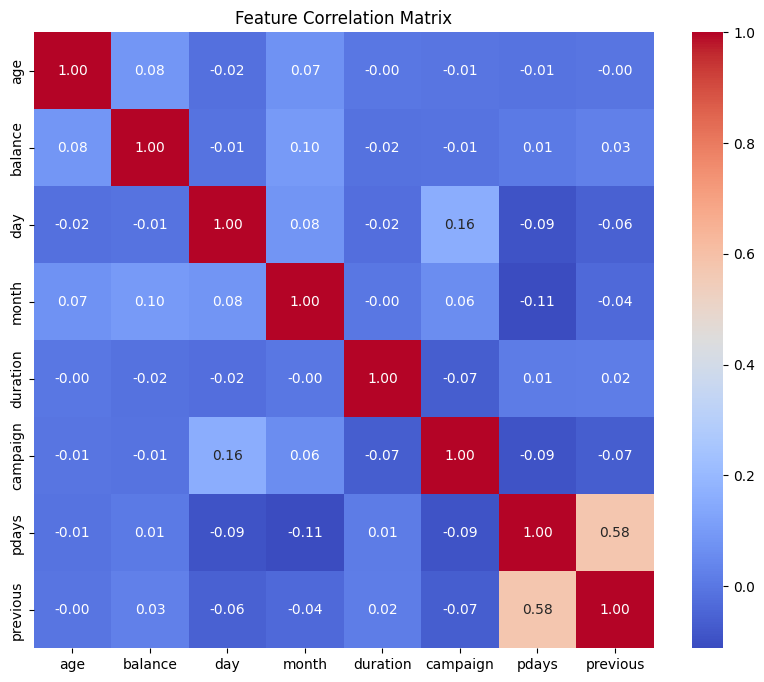

[2025-05-03 16:29:09,224: INFO: 4276966440: Feature correlation in the data:                age   balance       day     month  duration  campaign  \
age       1.000000  0.083820 -0.017853  0.073764 -0.002367 -0.005148   
balance   0.083820  1.000000 -0.008677  0.099872 -0.015950 -0.009976   
day      -0.017853 -0.008677  1.000000  0.080436 -0.024629  0.160706   
month     0.073764  0.099872  0.080436  1.000000 -0.000282  0.059214   
duration -0.002367 -0.015950 -0.024629 -0.000282  1.000000 -0.068382   
campaign -0.005148 -0.009976  0.160706  0.059214 -0.068382  1.000000   
pdays    -0.008894  0.009437 -0.094352 -0.112003  0.010380 -0.093137   
previous -0.003511  0.026196 -0.059114 -0.037410  0.018080 -0.067833   

             pdays  previous  
age      -0.008894 -0.003511  
balance   0.009437  0.026196  
day      -0.094352 -0.059114  
month    -0.112003 -0.037410  
duration  0.010380  0.018080  
campaign -0.093137 -0.067833  
pdays     1.000000  0.577562  
previous  0.577562  1.0000

In [33]:
#define the pipeline
try:
    config = ConfigurationManager()
    data_transformation_config = config.get_data_transformation_config() 
    data_transformation = DataTransformation(config=data_transformation_config)
    transform = data_transformation.initiate_data_transformation()
    data_transformation.split_data(transform)
    print("Data transformation completed successfully") 
except Exception as e:
    logger.exception(e)
    print(e)    